In [1]:
from dataclasses import dataclass
from typing import List, Dict, Set, Tuple, Any

import torch
import numpy as np

torch.manual_seed(2023)
np.random.seed(2023)


In [2]:
# make a torch dataset
from torch.utils.data import Dataset
from datasets.arrow_dataset import Dataset as D
from loguru import logger
from datasets import load_dataset
from tqdm.auto import tqdm


class SkipgramDataset(Dataset):
    def __init__(self,
                 n_instances: int,
                 window_size: int,
                 min_word_freq: int,
                 base_dataset_name: str = "multi_news",
                 pad_token:str = "[PAD]") -> None:
        
        # https://huggingface.co/datasets/multi_news
        self.base_dataset_name = base_dataset_name
        # how many instances from the dataset should be used
        # sure you can use the whole dataset but
        # that'll mean a lot of data and longer training time
        # if n_instances = -1, the whole dataset will be used
        self.n_instances = n_instances
        self.window_size = window_size
        self.min_word_freq = min_word_freq
        
        self.pad_token = pad_token
        
        # load dataset
        logger.info(f"Loading dataset :: {self.base_dataset_name}")
        
        if self.n_instances == -1:
            logger.warning("Using the whole dataset!")
            self.base_dataset = load_dataset(
                self.base_dataset_name)["train"][:]["document"]
        else:
            self.base_dataset = load_dataset(
                self.base_dataset_name)["train"][:self.n_instances]["document"]
        
        logger.info("Preprocessing ....")
        self.word_to_idx, self.word_freqs, self.vocabulary = self.__preprocess()
        
        self.vocab_size = len(self.vocabulary)
        logger.info(f"Vocabulary size :: {len(self.vocabulary)}")
        
        
        logger.info("Subsampling ....")
        self.subsampled_vocab = self.__subsample()
        self.sub_vocab_size = len(self.subsampled_vocab)
        logger.info(f"Subsampled Vocabulary Size :: {self.sub_vocab_size}")
        
        # create a reverse lookup table
        # int to word
        logger.info("Generating idx_to_word ....")
        self.idx_to_word = {self.word_to_idx.get(word): word for word in self.vocabulary}
        
        logger.info("Storing unigram probabilities ....")
        self.total_words = sum(self.word_freqs.values())
        
        
        # populate
        logger.info("Creating target context pairs ....")
        self.pairs = self.__create_target_context_pairs()
        logger.success(f"Done! Created {len(self.pairs)} instances.")
        
        
    # utils
    def __clean_and_tokenise(self, text: str) -> List[str]:
        # lowercase
        doc = text.lower()
        # replace space + newline with empty str
        doc = doc.replace(" \n", "")
        # split
        doc = doc.split()
        return doc
    
    def __preprocess(self) -> tuple:
        # word to idx mapping
        word_to_idx = dict()

        # frequencies
        word_freqs = dict()


        for _, ds in tqdm(enumerate(self.base_dataset), total=len(self.base_dataset), desc="update_freq"):
            doc = self.__clean_and_tokenise(ds)

            # update freq
            for word in doc:
                if not word in word_freqs.keys():
                    word_freqs[word] = 1
                else:
                    word_freqs[word] += 1


        # filter words which have a frequency of less than min_freq
        # as the final words list / vocabulary
        vocabulary = [w for w in word_freqs.keys() if word_freqs[w] >= self.min_word_freq]
            
        # sort vocabulary in the descending order of frequency
        vocabulary = sorted(vocabulary, key=word_freqs.get, reverse=True) # type: ignore
        
        # populate word_to_idx
        for idx, word in tqdm(enumerate(vocabulary), total=len(vocabulary), 
                          desc="word_to_idx"):
            word_to_idx[word] = idx
        

        return word_to_idx, word_freqs, vocabulary
    
    # select a subsampled list to be used as vocabulary from the main vocab list
    def __subsample(self) -> List[str]:
        T = 1e-5 # follwing the original threshold from the paper
        
        # probability for a single word using its frequency
        def subsample_probability(frequency):
            return 1 - np.sqrt(T / frequency)
        
        # freq(word) / vocab_size : what is the representation of the word in the total corpus
        # more frequent words such as the, to don't really contribute much to the meaning of another vector
        # and hence can be dropped for the sake of learning good word vectors
        # https://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
        scaled_frequencies = { word: self.word_freqs[word] / self.vocab_size for word in self.vocabulary } 
        
        
        # get the probability of a word to drop
        drop_probability = { word: subsample_probability(scaled_frequencies[word]) for word in self.vocabulary}
        
        # if probability of being dropped is drop_probability then for remaining, 1 - drop_probability
        subsampled_vocab = [word for word in self.vocabulary if np.random.rand() < (1 - drop_probability[word])]
        
        # update original vocabulary with the subsampled one
        return subsampled_vocab
    
    
    # the target word index is the index of the word in the list
    def __get_context_words(self, tokens: List[str], target_word_index: int) -> List[str]:
        # index range to look for
        # we look among window_size words left and right of the targer word in a sentence
        index_range = np.random.randint(1, self.window_size)
        
        # we look through all the tokens in a sentence and pick context words
        # excluding the target word
        
        start = max(0, target_word_index - index_range)
        finish = min(target_word_index + index_range, len(tokens) - 1)
        
        context_words = tokens[start: target_word_index] + tokens[target_word_index + 1 : finish + 1]
        # discard words which failed to meet min freq (in preprocessing)
        # and are not part of the vocab
        context_words = [cw for cw in context_words if self.word_to_idx.get(cw) is not None]
        
        return context_words
    
    def __create_target_context_pairs(self) -> Dict[str, Set]:
        pairs = dict()
        
        for _, sentence in tqdm(enumerate(self.base_dataset), 
                                  desc="create_pairs",
                                  total=len(self.base_dataset)):
            
            tokens = self.__clean_and_tokenise(sentence)
            for index, token in enumerate(tokens):
                context_words = self.__get_context_words(tokens, index)
                
                if token not in pairs.keys():
                    pairs[token] = set(context_words)
                else:
                    pairs[token].update(context_words)
            
        
        return pairs
    
    
    # dataset methods
    def __len__(self) -> int:
        return self.sub_vocab_size
    
    
    
    def __getitem__(self, index: int) -> Dict:
        target_word = self.vocabulary[index]
        all_context_words = list(self.pairs[target_word])
        
        # randomly pick one
        random_idx = np.random.randint(0, len(all_context_words))
        context_word = all_context_words[random_idx]
        
        
        target = self.word_to_idx[target_word]
        context = self.word_to_idx[context_word]
        
        
        target = torch.tensor(target, dtype=torch.long)
        context = torch.tensor(context, dtype=torch.long)
        
        return {
            "target": target,
            "context": context,
        }

    # for negative sampling
    def get_noise_distribution(self) -> torch.Tensor:        
        frequencies = torch.tensor([
            self.word_freqs[word] for word in self.vocabulary])

        # sort in the descending order
        frequencies, _ = torch.sort(frequencies, dim=-1, descending=True, stable=True)
        
        # unigram_probabilities
        unigram_probabilities = frequencies / frequencies.sum(dim=-1)
        
        unigram_distribution = unigram_probabilities / unigram_probabilities.sum(dim=-1)
        noise_distribution = torch.pow(unigram_distribution, 0.75) /  torch.pow(unigram_distribution, 0.75).sum(dim=-1)
        
        return noise_distribution

ds = SkipgramDataset(15000, 5, 5)


2023-10-21 04:03:01.013 | INFO     | __main__:__init__:30 - Loading dataset :: multi_news
2023-10-21 04:03:03.621 | INFO     | __main__:__init__:40 - Preprocessing ....


update_freq:   0%|          | 0/15000 [00:00<?, ?it/s]

word_to_idx:   0%|          | 0/146646 [00:00<?, ?it/s]

2023-10-21 04:03:09.633 | INFO     | __main__:__init__:44 - Vocabulary size :: 146646
2023-10-21 04:03:09.633 | INFO     | __main__:__init__:47 - Subsampling ....
2023-10-21 04:03:09.886 | INFO     | __main__:__init__:50 - Subsampled Vocabulary Size :: 47848
2023-10-21 04:03:09.886 | INFO     | __main__:__init__:54 - Generating idx_to_word ....
2023-10-21 04:03:09.910 | INFO     | __main__:__init__:57 - Storing unigram probabilities ....
2023-10-21 04:03:09.914 | INFO     | __main__:__init__:62 - Creating target context pairs ....


create_pairs:   0%|          | 0/15000 [00:00<?, ?it/s]

2023-10-21 04:04:57.130 | SUCCESS  | __main__:__init__:64 - Done! Created 721981 instances.


In [3]:
assert ds.get_noise_distribution().size()[0] == ds.vocab_size


In [4]:
from torch.utils.data import DataLoader

loader = DataLoader(ds, batch_size=128, shuffle=True)

# for batch in tqdm(loader):
#     batch["context"]


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [6]:
from einops import rearrange

class SkipgramModel(nn.Module):
    def __init__(self, vocab_size: int, 
                 vocabulary: List[str],
                 word_to_idx: Dict, 
                 embedding_dim: int, 
                 noise_distribution: torch.Tensor) -> None:
        super().__init__()
        
        self.vocabulary = vocabulary
        self.vocab_size = vocab_size
        self.word_to_idx = word_to_idx
        
        self.embedding_dim = embedding_dim
        self.noise_distribution = noise_distribution
        
        # layers
        self.word_embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.output_embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # uniform init
        self.word_embedding.weight.data.uniform_(-1, 1)
        self.output_embedding.weight.data.uniform_(-1, 1)
        
    
    def generate_noise(self, batch_size, device, n_samples=5) -> torch.Tensor:
        noise_word_idxs = torch.multinomial(self.noise_distribution, 
                                        num_samples=batch_size * n_samples, replacement=True)
        noise_word_idxs = noise_word_idxs.to(device)
        noise = self.output_embedding(noise_word_idxs)
        
        # reshape
        noise = rearrange(noise, "(batch samples) embed -> batch samples embed", 
                          batch=batch_size, samples=n_samples)
        
        return noise
        
    def forward(self, target, context) -> Tuple[torch.Tensor, torch.Tensor]:
        target_vectors = self.word_embedding(target)
        context_vectors = self.output_embedding(context)
        
        return target_vectors, context_vectors
        
        
model = SkipgramModel(ds.vocab_size, ds.vocabulary, ds.word_to_idx, 300, ds.get_noise_distribution())


In [7]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, target, context, noise):
        # rearrange for matrix multiplication
        target = rearrange(target, "batch embed -> batch embed 1")
        context = rearrange(context, "batch embed -> batch 1 embed")
        
        
        word_embedding_loss = torch.bmm(context, target).sigmoid().log().squeeze()
        noise_loss = torch.bmm(noise.neg(), target).sigmoid().log().squeeze()
        
        
        total_loss = - word_embedding_loss.neg() - noise_loss.sum(dim=-1)
        mean_loss = total_loss.mean(dim=-1)
        
        return mean_loss
        

criterion = NegativeSamplingLoss()

# with torch.no_grad():
#     for batch in loader:
#         tgt, ctx = model(batch["target"], batch["context"])
    
#         batch_size = tgt.size()[0]
#         noise = model.generate_noise(batch_size)
    
#         loss = criterion(tgt, ctx, noise)
#         print(loss.item())



In [8]:
optimiser = optim.AdamW(params=model.parameters(), lr=0.003)


In [9]:
from accelerate import Accelerator
accelerator = Accelerator()

model, optimiser, loader = accelerator.prepare(
    model, optimiser, loader
)


In [10]:
epochs = 15

steps = 0
global_losses = list()

for e in range(epochs):
    print(f"Epoch :: [{e + 1}] / [{epochs}]")
    epoch_losses = list()
    for batch in tqdm(loader):
        optimiser.zero_grad()
        
        target = batch["target"]
        context = batch["context"]
        
        tgt, ctx = model(target, context)
        noise = model.generate_noise(target.size()[0], accelerator.device)
        
        loss = criterion(tgt, ctx, noise)
        
        epoch_losses.append(loss.item())
        
        accelerator.backward(loss)
        optimiser.step()

    mean_epoch_loss = torch.tensor(epoch_losses).cpu().mean(dim=-1).item()
    print(f"Mean Loss/Train :: {mean_epoch_loss}")
    global_losses.append(mean_epoch_loss)
        

Epoch :: [1] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 9.55108642578125
Epoch :: [2] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 9.25668716430664
Epoch :: [3] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 8.915077209472656
Epoch :: [4] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 8.674628257751465
Epoch :: [5] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 8.359517097473145
Epoch :: [6] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 8.026081085205078
Epoch :: [7] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 7.695079326629639
Epoch :: [8] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 7.367856502532959
Epoch :: [9] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 6.905543804168701
Epoch :: [10] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 6.4404120445251465
Epoch :: [11] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 5.689761161804199
Epoch :: [12] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 4.876952648162842
Epoch :: [13] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 3.6497933864593506
Epoch :: [14] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 2.142040252685547
Epoch :: [15] / [15]


  0%|          | 0/374 [00:00<?, ?it/s]

Mean Loss/Train :: 0.4679592251777649


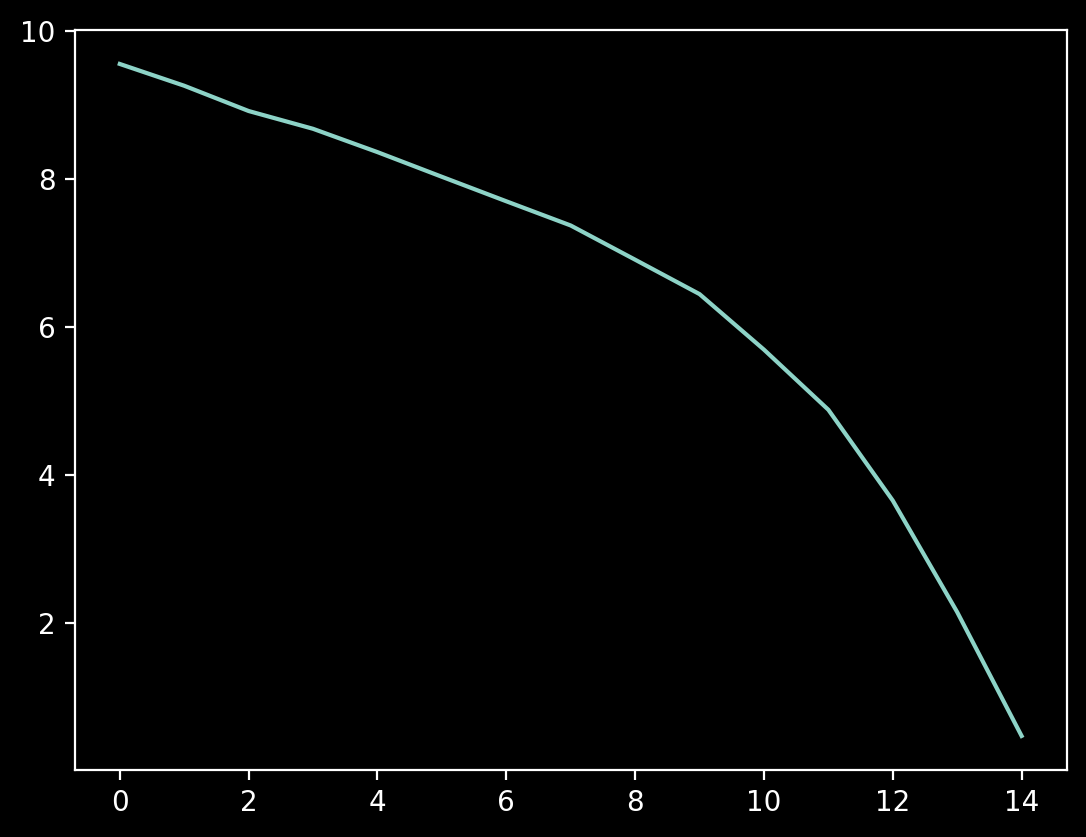

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(torch.arange(epochs).tolist(), global_losses)
plt.show()


In [12]:
embeddings = model.word_embedding.weight
embeddings.requires_grad = False
embeddings.size()


torch.Size([146646, 300])

In [13]:
# https://github.com/lukysummer/SkipGram_with_NegativeSampling_Pytorch/
from sklearn.manifold import TSNE

embeddings_np = embeddings.cpu().numpy()


In [14]:
n_words = 300
tsne = TSNE()

embeddings_tsne = tsne.fit_transform(embeddings_np[: n_words, :])


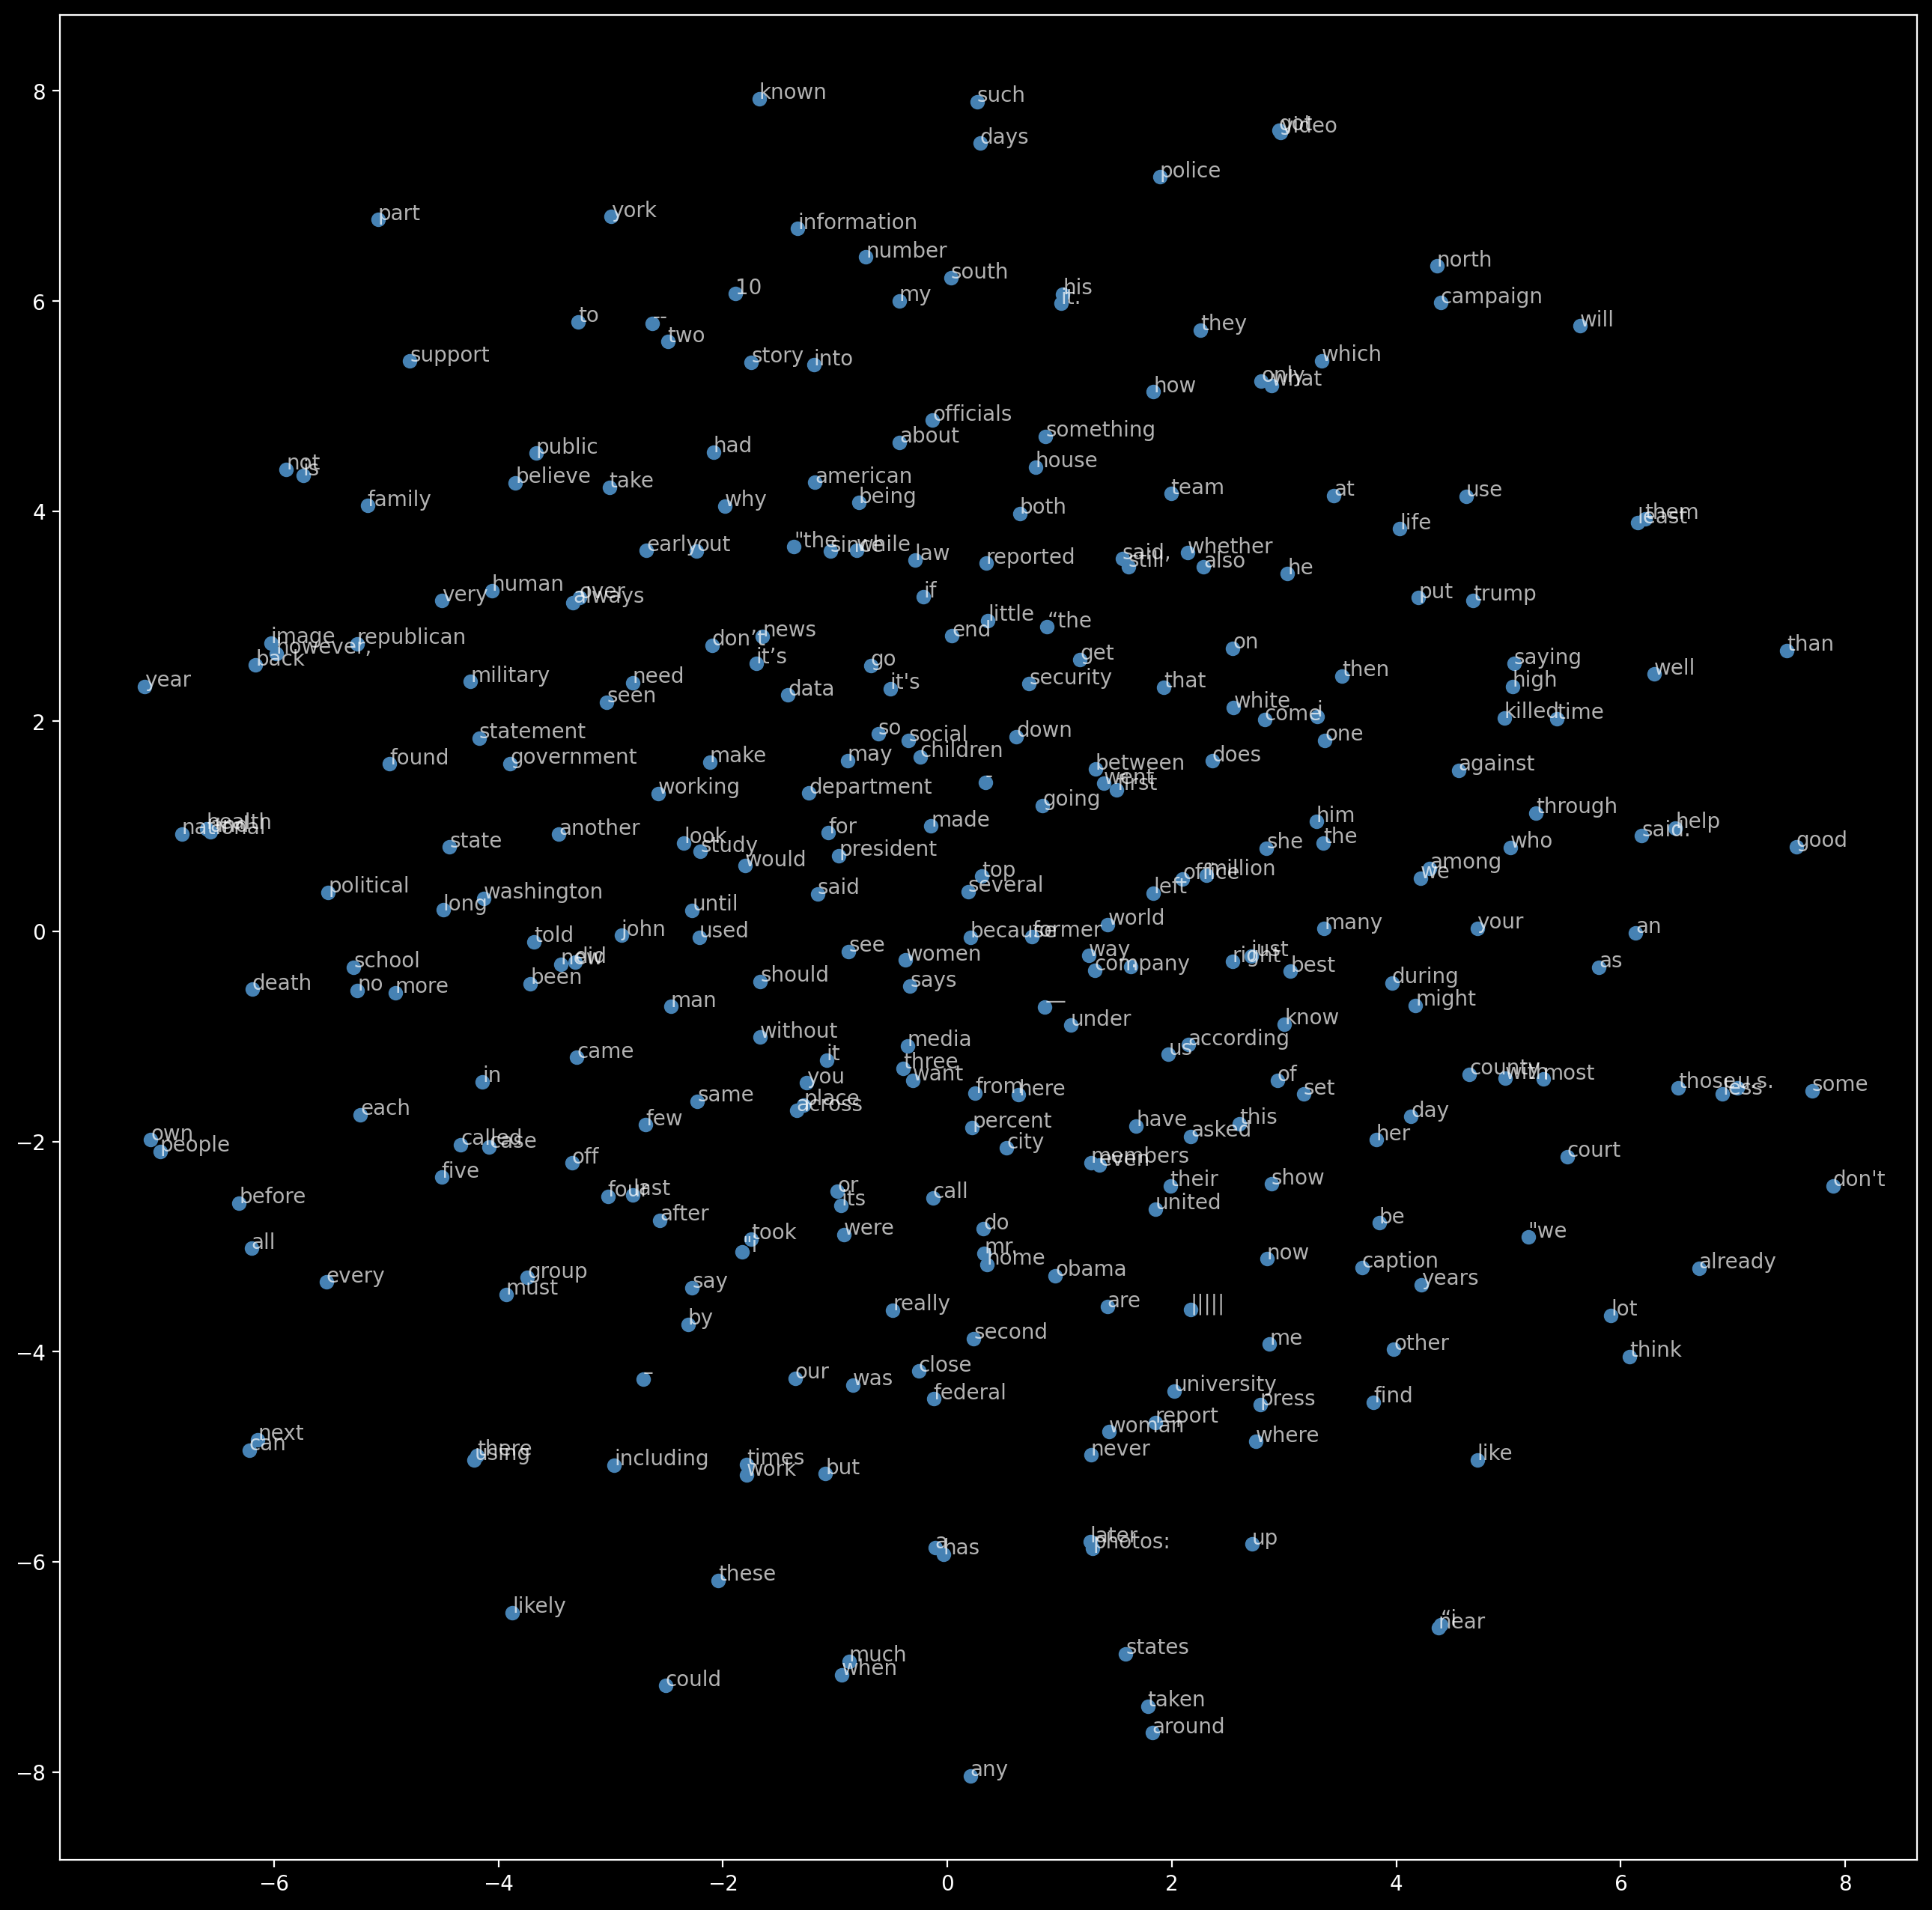

In [15]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(n_words):
    plt.scatter(*embeddings_tsne[idx, :], color='steelblue')
    plt.annotate(ds.vocabulary[idx], (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]), alpha=0.7)


In [19]:
def find_n_closest_words(word: str, embeddings: torch.Tensor, word_to_idx: dict, vocabulary: List[str], top_n: int) -> None:
    word_idx = word_to_idx.get(word)
    assert word_to_idx is not None
    
    scores = F.cosine_similarity(embeddings[word_idx], embeddings, dim=-1)
    sorted_scores, indices = torch.sort(scores, dim=-1, descending=True)
    
    sorted_scores = sorted_scores.cpu().tolist()[1: top_n]
    indices = indices.cpu().tolist()[1: top_n]
    
    print(f"{top_n} nearest words for :: {word} ::")
    for score, idx in zip(sorted_scores, indices):
        print(f"{vocabulary[idx]} --> {score}")
        
        
find_n_closest_words("university", embeddings, ds.word_to_idx, ds.vocabulary, top_n=50)
    


50 nearest words for :: university ::
haub, --> 0.2783220708370209
stroup, --> 0.2461504489183426
"lost --> 0.24164265394210815
kolber --> 0.23763439059257507
homes. --> 0.23744624853134155
lures --> 0.22882777452468872
perceive --> 0.2275877296924591
topic.” --> 0.22601158916950226
regina --> 0.22294053435325623
monitors. --> 0.22276687622070312
deed --> 0.22199052572250366
cynical --> 0.22114141285419464
practically --> 0.22031894326210022
actions, --> 0.21884343028068542
torquing’s --> 0.2157430350780487
question... --> 0.21421019732952118
sneakers. --> 0.21351397037506104
glasgow, --> 0.2125554084777832
reynaldo --> 0.21177886426448822
remedy. --> 0.2116837203502655
beads, --> 0.21031996607780457
"dylan --> 0.2087268829345703
true}); --> 0.20862960815429688
healthy --> 0.20820051431655884
“epl” --> 0.20797841250896454
blessing.” --> 0.20779374241828918
girls. --> 0.20760919153690338
eaten. --> 0.20670734345912933
aléas --> 0.20650172233581543
bessemer --> 0.20638039708137512
$132,0